# Подготовка библиотек

In [1]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [2]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qdqxa58n
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-qdqxa58n


In [3]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

# Проверить устройства для кераса

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17236525210827863171
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3123979531930168761
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [5]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [6]:
DATASET_PATH = 'clothing-co-parsing/photos/'
MASKS_PATH = 'clothing-co-parsing/annotations/pixel-level/'

In [7]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [8]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(DATASET_PATH + image_filename))
    images.append(preprocess_image(image))

    mask_file = io.loadmat(MASKS_PATH + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth']) 
    masks.append(preprocess_mask(mask))

In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [10]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [11]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [12]:
len(train)

6424

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

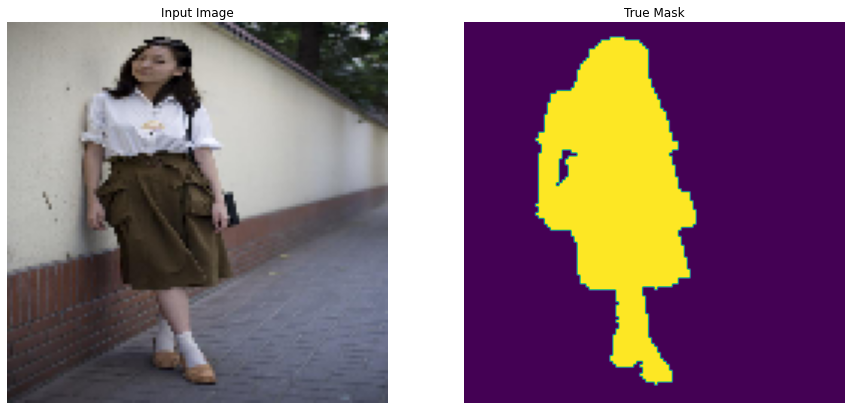

In [15]:
for image, mask in test.take(5):
  sample_image, sample_mask = image, mask
display([sample_image[0,:,:,:], sample_mask[0,:,:,:]])

In [71]:
sample_image.shape

TensorShape([32, 128, 128, 3])

In [16]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0, 1)

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Тренировка модели с метрикой dice_coef
Будем использовать - `losses.SparseCategoricalCrossentropy(from_logits=True)`. Причина использования данной loss-функции заключается в том, что у нас 3, а не один. 

In [21]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [22]:
from tensorflow.keras import backend as K
# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [72]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              # loss='categorical_crossentropy',              
              metrics=[dice_coef])

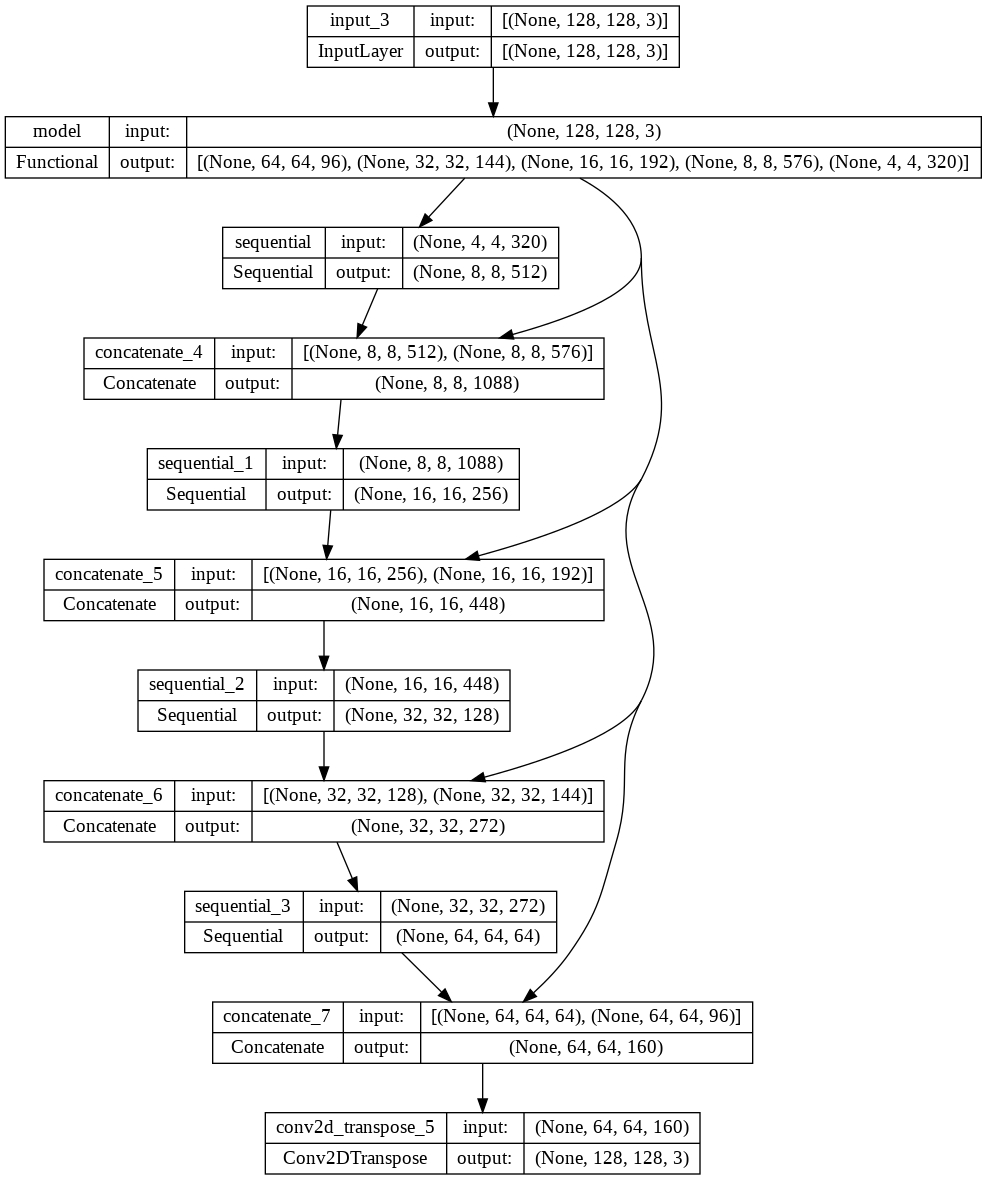

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True)

Определяем callback функцию для  мониторинга того как улучшается работа модели в процессе обучения.

In [54]:
class DisplayCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        # show_predictions(self.model, self.dataset, self.num)
        show_predictions(self.model, train)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 89ms/step


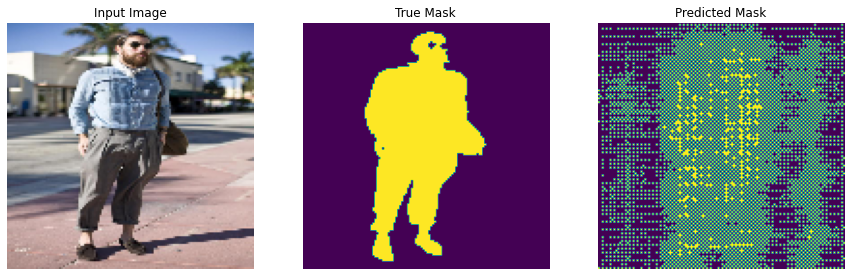


Sample Prediction after epoch 20

1/1 [==============================] - 2s 2s/step - loss: 0.5356 - dice_coef: 0.4876 - val_loss: 1.4325 - val_dice_coef: -0.4368


In [82]:
EPOCHS = 20 
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test)//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

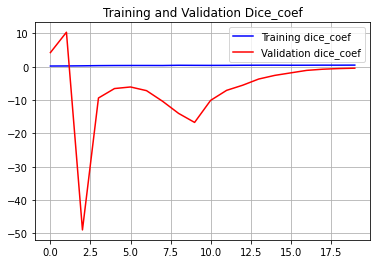

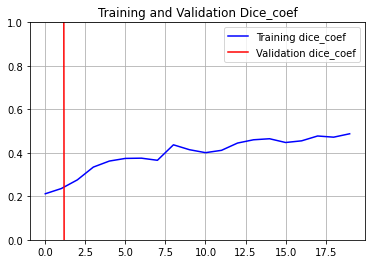

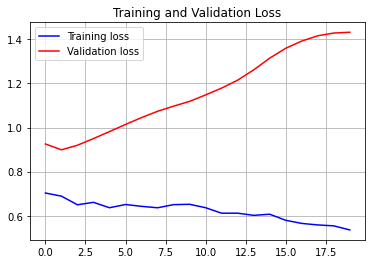

In [91]:
metr = model_history.history['dice_coef']
metr_v = model_history.history['val_dice_coef']
loss = model_history.history['loss']
loss_v = model_history.history['val_loss']

epochs = range(len(metr))

plt.plot(epochs, metr, 'b', label='Training dice_coef')
plt.plot(epochs, metr_v, 'r', label='Validation dice_coef')
plt.grid('on')
plt.legend()
plt.title('Training and Validation Dice_coef')

plt.figure()

plt.plot(epochs, metr, 'b', label='Training dice_coef')
plt.plot(epochs, metr_v, 'r', label='Validation dice_coef')
plt.grid('on')
plt.ylim(0, 1)
plt.legend()
plt.title('Training and Validation Dice_coef')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_v, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.grid('on')
plt.legend()

plt.show()

### Тренировка модели с метрикой accuracy

In [84]:
model_acc = unet_model(OUTPUT_CHANNELS)
model_acc.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

1/1 [==============================] - 0s 24ms/step


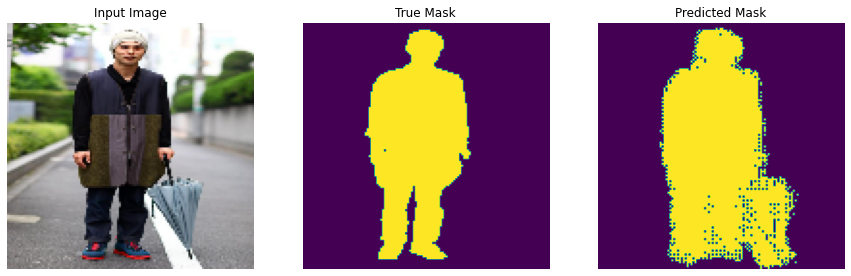


Sample Prediction after epoch 20

1/1 [==============================] - 2s 2s/step - loss: 0.2216 - accuracy: 0.9152 - val_loss: 0.2588 - val_accuracy: 0.9236


In [85]:
EPOCHS = 20
VAL_SUBSPLITS = 5

model_acc_history = model_acc.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

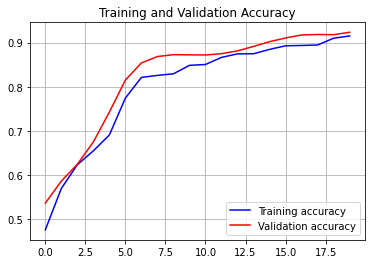

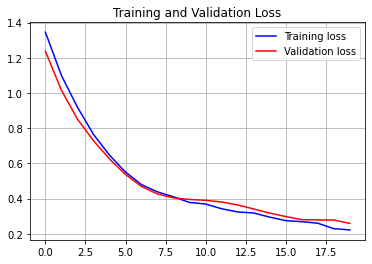

In [86]:
acc = model_acc_history.history['accuracy']
acc_v = model_acc_history.history['val_accuracy']
loss = model_acc_history.history['loss']
loss_v = model_acc_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, acc_v, 'r', label='Validation accuracy')
plt.grid('on')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_v, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.grid('on')
plt.legend()

plt.show()

### Вывод

На данном датасте применение в модели U-Net метрики Деци дает явно хидший результат, чем в случае accuracy.

1/1 [==============================] - 0s 44ms/step


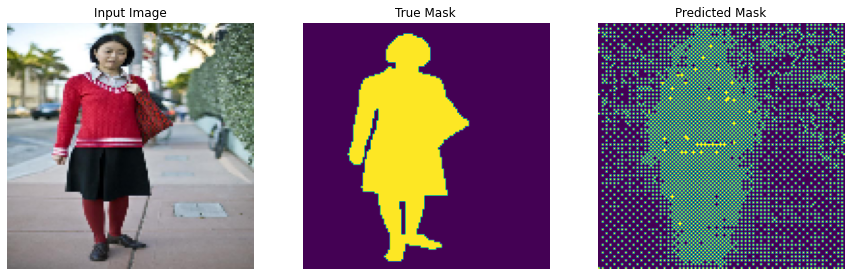

In [89]:
show_predictions(model, test, 1)

1/1 [==============================] - 0s 25ms/step


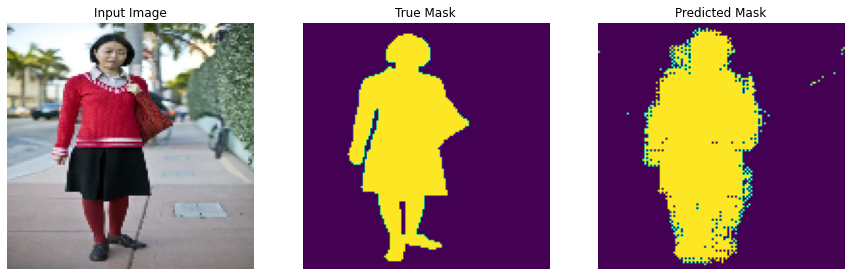

In [90]:
show_predictions(model_acc, test, 1)